In [2]:
#!pip install git+https://github.com/tensorflow/docs
#!pip install matplotlib numpy pandas seaborn sklearn

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
#import tensorflow_docs as tfdocs
#import tensorflow_docs.modeling
#import tensorflow_docs.plots

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)
#logdir = "./tensorlogs/tensorboard_logs"
#shutil.rmtree(logdir, ignore_errors=True)

print(tf.__version__)

2.9.1


In [3]:
# Testy dla kobaltu
keys_cobalt = ['PTA.1BD03401_DT04.PV', 'PTA.FC1231.PV', 'PTA.1BD03401_DT07.PV', 'PTA.FC1233.PV', 'PTA.X1311.PV', 'PTA.SMP14514CBACON.PV']
# Testy dla manganu
keys_mangan = ['PTA.1BD03401_DT05.PV', 'PTA.FC1231.PV', 'PTA.1BD03401_DT08.PV', 'PTA.FC1233.PV', 'PTA.X1311.PV', 'PTA.SMP14514CBACON.PV']
# Testy dla bromu
keys_bromium = ['PTA.1BD03401_DT06.PV', 'PTA.FC1232.PV', 'PTA.1BD03401_DT09.PV', 'PTA.FC1233.PV', 'PTA.X1311.PV', 'PTA.SMP14514CBACON.PV']
# Testy dla bromu z CRU
keys_bromium_cru = ['PTA.1BD03401_DT09.PV', 'PTA.FC1233.PV', 'PTA.1BD03401_DT06.PV', 'PTA.FC1232.PV', 'PTA.1BD03401_DT09.PV', 'PTA.FC1233.PV', 'PTA.X1311.PV', 'PTA.SMP14514CBACON.PV']
# Testy dla cisnienia
keys_prsesure = ['PTA.PC1311.PV', 'PTA.X1311.PV', 'PTA.SMP14514CBACON.PV']

# wybór co testujemy - wybierz sobie z jednego powyżej
keys_full = keys_cobalt

# reszty nie musisz ruszac

model_types = ['regression', 'classification']
output_keys = ['PTA.X1311.PV', 'PTA.SMP14514CBACON.PV']
output_keys_classification = ['PTA.X1311.PV_TRAN', 'PTA.SMP14514CBACON.PV_TRAN']

loss_fn_configurations = ['mse', 'binary_crossentropy']
output_keys_configurations = [[output_keys[0]], [output_keys[1]]]
layers_configurations = [ [30, 10, 3], [50,25,10], [75, 15, 3], [75, 25, 10], [128, 32, 8], [256, 64, 16] ]
activation_fn_regression = ['relu']
activation_fn_classification = ['softmax', 'sigmoid']

batch_size=32

test_results = {}
prediction_results = {}

In [4]:
# url = './data/csv_Data_Rev.1.csv'
# nowe dane
url = './data/Data_Rev.3.csv'

raw_dataset = pd.read_csv(url,
                          na_values='?',
                          sep=';', skipinitialspace=True)

dataset = raw_dataset.copy()

def replaceStringWithNumber(val):
    return float(val.replace(',','.').replace(' ', ''))

dataset_reduced = dataset[keys_full].copy()
#dataset_reduced.tail()
for key in keys_full:
  dataset_reduced[key] = dataset_reduced.apply(lambda x: replaceStringWithNumber(x[key]), axis=1)
#dataset_reduced.isnull().sum()
    

    
def prepare_datasets(output_labels):
    #prepare_main_dataset()
    train_dataset = dataset_reduced.sample(frac=0.8, random_state=0)
    test_dataset = dataset_reduced.drop(train_dataset.index)
    
    train_labels = train_dataset[output_labels].copy()
    test_labels = test_dataset[output_labels].copy()
    
    train_features = train_dataset.drop(output_keys, axis=1)
    test_features = test_dataset.drop(output_keys, axis=1)

    return train_features, train_labels, test_features, test_labels

In [5]:
#train_features, train_labels, test_features, test_labels = prepare_normalized_datasets(output_keys[1], False, 25)
train_features, train_labels, test_features, test_labels = prepare_datasets(output_keys[1])
train_features.tail()

v  PTA.1BD03401_DT05.PV  PTA.FC1231.PV  PTA.1BD03401_DT06.PV  \
9564   3.7                   1.9         313.02                  48.0   
29832  4.0                   2.1         237.20                  48.0   
36058  2.4                   1.3         184.31                  48.0   
23409  3.6                   2.4         215.79                  48.0   
37409  2.9                   1.1         195.87                  48.0   

       PTA.FC1232.PV  PTA.1BD03401_DT07.PV  PTA.1BD03401_DT08.PV  \
9564           65.60                  0.42                  0.29   
29832          24.21                  0.44                  0.31   
36058           0.43                  0.40                  0.18   
23409           0.33                  0.22                  0.09   
37409           0.45                  0.25                  0.25   

       PTA.1BD03401_DT09.PV  PTA.FC1233.PV  PTA.FC1314.PV  ...  \
9564                   5.74           0.95            7.5  ...   
29832                  3.80         318.99            8.0  ...   
36058                  4.56         205.73            7.5  ...   
23409                  4.26         611.17            8.5  ...   
37409                  3.50         370.14            7.5  ...   

       PTA.Zawiesina_AA_V-1341_SMP-1341_Zawiesina_AA_V-1341_Suma_bromkow_ppm_m_m.LAB  \
9564                                               657.0                               
29832                                              861.0                               
36058                                              335.0                               
23409                                              571.0                               
37409                                              660.0                               

       PTA.Zawiesina_AA_V-1341_SMP-1341_Zawiesina_AA_V-1341_Zaw_kobaltu_Co_ppm_m_m.LAB  \
9564                                               516.0                                 
29832                                              772.0                                 
36058                                              667.0                                 
23409                                              442.0                                 
37409                                              610.0                                 

       PTA.Zawiesina_AA_V-1341_SMP-1341_Zawiesina_AA_V-1341_Zawartosc_Manganu_ppm_m_m.LAB  \
9564                                               304.0                                    
29832                                              399.0                                    
36058                                              382.0                                    
23409                                              268.0                                    
37409                                              276.0                                    

       PTA.Zawiesina_AA_V-1341_SMP-1341_Zawiesina_AA_V-1341_Zaw_kwasu_benzoesowego_ppm_m_m.LAB  \
9564                                             12912.0                                         
29832                                            10820.0                                         
36058                                            19489.0                                         
23409                                            12234.0                                         
37409                                            16401.0                                         

       PTA.FC1551.PV  PTA.F1544.PV  \
9564            2.91       3885.35   
29832           2.90       2461.18   
36058           2.81       4185.76   
23409           2.82       3554.10   
37409           2.04       2835.03   

       PTA.CIECZ_MA_D-1542_SMP-1542_CIECZ_MA_D-1542_OCTAN_METYLU_PRC_M_M_.LAB  \
9564                                               94.31                        
29832                                              94.33                        
36058                                              93.95                  

In [6]:
from sklearn.decomposition import PCA

def zamian_na_klasyfikacje_efektywnosc(value):
    if value == 0.08:
        return 1
    else:
        return 0
    
def zamian_na_klasyfikacje_efektywnosc_zakres(value):
    if value >= 0.07 and value <= 0.09:
        return 1
    else:
        return 0
    
def zamian_na_klasyfikacje_ppm(value):
    if value >= 2500 and value <= 3500:
        return 1
    else:
        return 0

def prepare_normalized_datasets(output_label, classification, num_pca_components=25):
    dataset_reduced_without_output_keys = dataset_reduced.drop(output_keys, axis=1)
    
    # normalizacja, redukcja PCA, transformacja PCA
    normalizer = tf.keras.layers.Normalization(axis=-1)
    normalizer.adapt(np.array(dataset_reduced_without_output_keys))
    normalized_dataset_reduced = normalizer(dataset_reduced_without_output_keys).numpy()
    pca = PCA(n_components=num_pca_components)
    pca.fit(normalized_dataset_reduced)
    suma = 0
    for i in pca.explained_variance_ratio_:
        suma = suma +i
    print("Sum of pca components: "+str(suma))
    pca_reduced_dataset = pca.transform(normalized_dataset_reduced)

    # etykiety
    dataset_output_keys = dataset_reduced[output_label].copy()
    pd_dataset_output_keys = pd.DataFrame(dataset_output_keys)
    
    # Obliczanie wartości pod klasyfikacje (0 lub 1)
    if output_label == output_keys[0]:
        pd_dataset_output_keys[output_label+'_TRAN'] = pd_dataset_output_keys.apply(lambda x: zamian_na_klasyfikacje_efektywnosc(x[output_label]), axis=1) 
    elif output_label == output_keys[1]:
        pd_dataset_output_keys[output_label+'_TRAN'] = pd_dataset_output_keys.apply(lambda x: zamian_na_klasyfikacje_ppm(x[output_label]), axis=1)
    pandas_pca_reduced_dataset = pd.DataFrame(pca_reduced_dataset)


    concat_dataset =  pd.concat([pandas_pca_reduced_dataset, pd_dataset_output_keys], axis=1)
    concat_dataset.tail()

    train_dataset = concat_dataset.sample(frac=0.8, random_state=0)
    test_dataset = concat_dataset.drop(train_dataset.index)

    # Dla regresji
    if(classification == False): # zostawiamy dane dla regresji
        train_labels = train_dataset[output_label].copy()
        test_labels = test_dataset[output_label].copy()

        train_features = train_dataset.drop([output_label, output_label+'_TRAN'], axis=1)
        test_features = test_dataset.drop([output_label, output_label+'_TRAN'], axis=1)
        return train_features, train_labels, test_features, test_labels
    else:    # Dla KLASYFIKACJI
        train_labels = train_dataset[output_label+'_TRAN'].copy()
        test_labels = test_dataset[output_label+'_TRAN'].copy()

        train_features = train_dataset.drop([output_label, output_label+'_TRAN'], axis=1)
        test_features = test_dataset.drop([output_label, output_label+'_TRAN'], axis=1)
        return train_features, train_labels, test_features, test_labels
    

In [7]:
import collections.abc
def get_model_name(output_keys_conf, layer_conf, loss_fn, short, final_activation_fn):
    output = ''
    if short == False:
        output = 'sizes/'
    if isinstance(output_keys_conf, collections.abc.Sequence):
        for key in output_keys_conf:
            output += str(key)
            output += '_'    
    else:
        output += str(output_keys_conf)
        output += '_'
            
    for l in layer_conf:
        output = output + str(l) + '_'
    
    output += loss_fn
    output += '_'+final_activation_fn
    
    return output

# Test
get_model_name(['XYZ', 'ABC'], [3, 3], 'mae', True, 'sigmoid')

'XYZ_ABC_3_3_mae_sigmoid'

In [8]:
def plot_true_vs_prediction(true_labels, predicted_labels, lim_start, lim_end):
    a = plt.axes(aspect='equal')
    plt.scatter(true_labels, predicted_labels)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    lims = [lim_start, lim_end]
    plt.xlim(lims)
    plt.ylim(lims)
    _ = plt.plot(lims, lims)

In [9]:
def plot_fitting(true_labels, predicted_labels):
    x_ax = range(len(true_labels))
    plt.scatter(x_ax, true_labels[:],  s=6, label="observed values", c='coral')
    plt.plot(x_ax, predicted_labels[:], label="predicted values",c='blue')
    plt.legend()
    plt.show()

In [10]:
def binary_activation(x):
    cond = tf.less(x, tf.fill(tf.shape(x), 0.5))
    #cond = tf.less(x, tf.zeros(tf.shape(x)))
    out = tf.where(cond, tf.zeros(tf.shape(x)), tf.ones(tf.shape(x)))
    return out

def build_and_compile_any_model(input_dim, layer_sizes, output_dim, loss_fn, norm, output_activation_fn):
  tab_layers = [
      norm, 
      layers.Dense(layer_sizes[0], kernel_regularizer=regularizers.l2(0.0001), input_dim=input_dim, activation='relu'),
      layers.Dropout(0.5)
  ]
  for i in range(len(layer_sizes)):
      if i == 0: continue
      else:
        tab_layers.append(layers.Dense(layer_sizes[i], kernel_regularizer=regularizers.l2(0.0001), activation='relu'))
        tab_layers.append(layers.Dropout(0.5))
    

  if output_activation_fn == 'softmax':
    tab_layers.append(layers.Dense(2, activation='softmax'))
    tab_layers.append(layers.Dense(output_dim, activation='sigmoid'))
  else:
    tab_layers.append(layers.Dense(output_dim, activation=output_activation_fn))
  #tab_layers.append(layers.Dense(output_dim, activation=binary_activation))
      
  model = keras.Sequential(tab_layers)

  model.compile(loss=loss_fn,
                optimizer=tf.keras.optimizers.Adam(0.001), metrics=['mae', 'mse', 'mean_absolute_percentage_error', 'binary_crossentropy'])
  return model

In [11]:
import os
def get_checkpoint_dir(name):
    checkpoint_path = "checkpoints/"+name+".ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)
    return checkpoint_path

def get_callbacks(name):
    callback_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
    #callback_tensorboard = tf.keras.callbacks.TensorBoard(logdir+"/"+name)
    callback_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=get_checkpoint_dir(name),
                                                 save_weights_only=True,
                                                 save_freq=5*batch_size,
                                                 verbose=0)
    return [callback_early_stopping, callback_checkpoint]


In [ ]:
classification_problem = False # Jeśli False to robi regresje, Jeśli True będzie robił klasyfikację
pca_components = 4 # liczba komponentów PCA - pamiętaj, że teraz pracujemy na ograniczonym modelu danych tam jest niewiele kolumn
model_layers = [5, 3, 2] # konfiguracja warstw (nie wpisujemy tu wymiaru danych - 0 warstwa, to wchodzi z automatu)
no_outputs = 1 # liczba wyjsc - tego nie ruszamy
# funkcja kosztu
loss_fn = 'mse'
# funkcja aktywacji
activation_fn = 'relu'
# okreslenie kolumny wyjsciowej - one sa zapisane w tabeli output_keys - wiec po prostu wskaz czy [0] czy [1]
#(indeks spalania tj PTA.X1311.PV -> output_keys[0], zanieczyszczenia tj. PTA.SMP14514CBACON.PV -> output_keys[1])
selected_feature = output_keys[0]  


train_features, train_labels, test_features, test_labels = prepare_normalized_datasets(selected_feature, classification_problem, pca_components)
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))

model_name = get_model_name(selected_feature, model_layers, loss_fn, classification_problem, activation_fn)

dnn_model = build_and_compile_any_model(len(train_features.columns), model_layers, no_outputs, loss_fn, normalizer, activation_fn) 
size_histories = dnn_model.fit(
    train_features,
    train_labels,
    batch_size=32,
    validation_split=0.2, callbacks=get_callbacks(model_name),
    verbose=1, epochs=400)
dnn_model.save('./models/'+model_name)

In [14]:
def plot_loss(history, lim_start, lim_end):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([lim_start, lim_end])
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

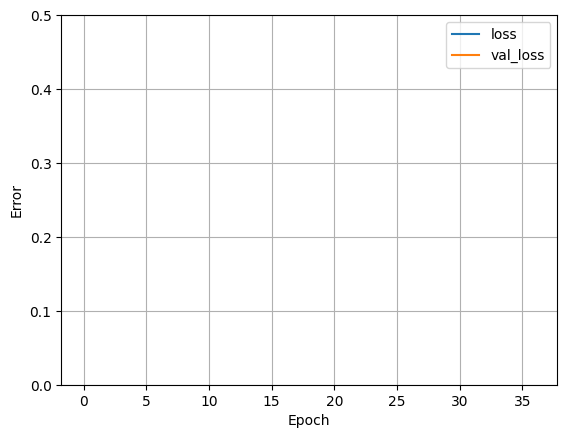

In [16]:
# 'PTA.X1311.PV', [75, 50, 25, 10], 'mse', False, 'relu'
plot_loss(size_histories, 0.00, 0.50)

In [22]:
# generowanie predykcji przez utworozny model
prediction_results = dnn_model.predict(test_features)

2022-08-12 11:41:07.341276: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


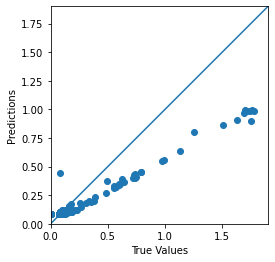

In [15]:
# rysowanie predykcji 
plot_true_vs_prediction(test_labels, prediction_results, 0.0, 1.9)

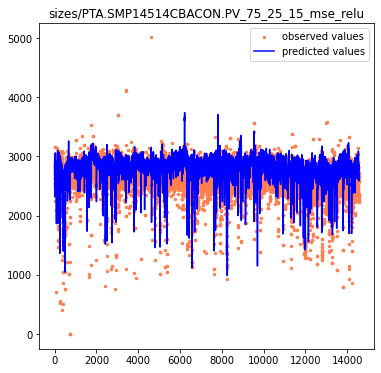

In [15]:
# jeszcze raz rysowanie predykcji - tylko inaczej
plt.figure(figsize=(6,6))
x_ax = range(len(test_labels))
plt.scatter(x_ax, test_labels[:],  s=6, label="observed values", c='coral')
plt.title(model_name)
plt.plot(x_ax, prediction_results[:], label="predicted values",c='blue')
plt.legend()
plt.show()

In [46]:
def zaokraglij(value):
    if value >= 0.5:
        return 1
    else:
        return 0

def ocen(real_value, predicted_value):
    if(real_value == 0 and predicted_value == 0): return 'TN'
    if(real_value == 0 and predicted_value == 1): return 'FP'
    if(real_value == 1 and predicted_value == 0): return 'FN'
    if(real_value == 1 and predicted_value == 1): return 'TP'

pd_prediction_results = pd.DataFrame(prediction_results)
pd_prediction_results['rounded'] = pd_prediction_results.apply(lambda x: zaokraglij(x[0]), axis=1)
pd_prediction_results.reset_index(drop=True, inplace=True)
test_labels.reset_index(drop=True, inplace=True)
pd_prediction_results =  pd.concat([pd_prediction_results, test_labels], axis=1)
pd_prediction_results['label'] = pd_prediction_results.apply(lambda x: ocen(x[output_keys[0]+'_TRAN'], x['rounded']), axis=1)
print(pd_prediction_results['label'].value_counts())

TN    7619
TP    6202
FP     674
FN      66
Name: label, dtype: int64


# Stare analizy

In [9]:
dataset_reduced_without_output_keys = dataset_reduced.drop(output_keys, axis=1)

In [10]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(dataset_reduced_without_output_keys))

Metal device set to: Apple M1 Pro


2022-08-08 21:46:08.563943: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-08 21:46:08.564080: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-08-08 21:46:08.602058: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-08-08 21:46:08.659066: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-08 21:46:08.675599: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [11]:
normalized_dataset_reduced = normalizer(dataset_reduced_without_output_keys).numpy()

In [12]:
#!pip install scikit-learn
from sklearn.decomposition import PCA
pca = PCA(n_components=25)
pca.fit(normalized_dataset_reduced)

PCA(n_components=25)

In [13]:
print(pca.explained_variance_ratio_)

[0.252 0.131 0.051 0.043 0.036 0.036 0.033 0.031 0.03  0.029 0.025 0.022
 0.02  0.019 0.018 0.016 0.016 0.015 0.014 0.013 0.013 0.012 0.011 0.01
 0.01 ]


In [14]:
suma = 0
for i in pca.explained_variance_ratio_:
    suma = suma +i
suma

0.906407480161845

In [15]:
# znormalizowane features bez kolumn wynikowych poddawane transformacji - redukcja wymiarow
pca_reduced_dataset = pca.transform(normalized_dataset_reduced)

In [16]:
pca_reduced_dataset

array([[-2.656, -2.823,  5.172, ..., -0.056, -0.003, -0.207],
       [-2.468, -2.712,  5.06 , ..., -0.039,  0.075, -0.183],
       [-2.443, -2.84 ,  5.144, ..., -0.006,  0.053, -0.019],
       ...,
       [-2.853,  2.278,  0.803, ..., -0.193,  0.13 , -0.847],
       [-2.833,  2.169,  0.891, ..., -0.243,  0.014, -0.905],
       [-3.019,  2.293,  0.625, ..., -0.318, -0.001, -0.833]],
      dtype=float32)

In [17]:
# przygotowanie datasetu z wynikami - kolumna PTA.X1311.PV
dataset_output_keys = dataset_reduced[output_keys[0]].copy()
dataset_output_keys.tail()

72801    0.08
72802    0.08
72803    0.07
72804    0.07
72805    0.07
Name: PTA.X1311.PV, dtype: float64

In [18]:
# zamiana wartości na klasyfikacje
def zamian_na_klasyfikacje(value):
    if value == 0.08:
        return 1
    else:
        return 0

pd_dataset_output_keys = pd.DataFrame(dataset_output_keys)
    
#   dataset_reduced[key] = dataset_reduced.apply(lambda x: replaceStringWithNumber(x[key]), axis=1)
pd_dataset_output_keys['PTA.X1311.PV_TRAN'] = pd_dataset_output_keys.apply(lambda x: zamian_na_klasyfikacje(x['PTA.X1311.PV']), axis=1)
pd_dataset_output_keys.tail()

PTA.X1311.PV  PTA.X1311.PV_TRAN
72801          0.08                  1
72802          0.08                  1
72803          0.07                  0
72804          0.07                  0
72805          0.07                  0

In [91]:
pandas_pca_reduced_dataset = pd.DataFrame(pca_reduced_dataset)

# łączenie features (po PCA) i kolumn wyjścia (obserwowanych wyników)
concat_dataset =  pd.concat([pandas_pca_reduced_dataset, pd_dataset_output_keys], axis=1)
concat_dataset.tail()

train_dataset = concat_dataset.sample(frac=0.8, random_state=0)
test_dataset = concat_dataset.drop(train_dataset.index)

# Dla regresji
train_labels = train_dataset[['PTA.X1311.PV']].copy()
test_labels = test_dataset[['PTA.X1311.PV']].copy()

train_features = train_dataset.drop(['PTA.X1311.PV', 'PTA.X1311.PV_TRAN'], axis=1)
test_features = test_dataset.drop(['PTA.X1311.PV', 'PTA.X1311.PV_TRAN'], axis=1)

# Dla KLASYFIKACJI
#train_labels = train_dataset[['PTA.X1311.PV_TRAN']].copy()
#test_labels = test_dataset[['PTA.X1311.PV_TRAN']].copy()

#train_features = train_dataset.drop(['PTA.X1311.PV', 'PTA.X1311.PV_TRAN'], axis=1)
#test_features = test_dataset.drop(['PTA.X1311.PV', 'PTA.X1311.PV_TRAN'], axis=1)


In [97]:
train_labels

19289    0.10
69376    0.07
54259    0.08
70999    0.08
22961    0.10
         ... 
9564     0.09
29832    0.08
36058    0.09
23409    0.09
37409    0.09
Name: PTA.X1311.PV, Length: 58245, dtype: float64

In [117]:


#normalizer = tf.keras.layers.Normalization(axis=-1)
#normalizer.adapt(np.array(train_features))

#dnn_model = build_and_compile_any_model(len(train_features.columns), [512, 256, 128], 1, ['mse'], normalizer)
#dnn_model = build_and_compile_any_model(len(train_features.columns), [512, 256, 128], 1, ['binary_crossentropy'], normalizer)
#dnn_model = build_and_compile_any_model(len(train_features.columns), [50, 25, 10], 1, ['binary_crossentropy'], normalizer, 'softmax')
#dnn_model = build_and_compile_any_model(len(train_features.columns), [50, 25, 10], 1, ['binary_crossentropy'], normalizer, 'sigmoid')
#dnn_model = build_and_compile_any_model(len(train_features.columns), [50, 25, 10], 1, ['mse'], normalizer, 'sigmoid') - bardzo dobrze !!!! - klasyfikacja
# wersja z dodaną dodatkową wartstwą za sigmoid z 2 neuronami softmax - bardzo słabo wyszła
# dnn_model = build_and_compile_any_model(len(train_features.columns), [50, 25, 10], 1, ['mse'], normalizer, 'softmax') - słabiutko
# ('PTA.X1311.PV_TRAN', [128,64,10], 'mse', False, 'sigmoid') - trochę lepiej niż 50, 25, 10, 1 - więcej True positive i True Negative
#output_keys_conf, layer_conf, loss_fn, short
# sprobowac jeszcze raz # malutki 20, 10, 5, 1, mse, sigmoid

# [15, 10, 5] binary_cross, relu - regresja - tak sobie dla wiekszych wartosci

#train_features, train_labels, test_features, test_labels = prepare_normalized_datasets(output_keys[0], True, 25)
train_features, train_labels, test_features, test_labels = prepare_normalized_datasets(output_keys[0], False, 25)
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))

model_name = get_model_name('PTA.X1311.PV', [128, 64, 16], 'binary_crossentropy', False, 'relu')
dnn_model = build_and_compile_any_model(len(train_features.columns), [128, 64, 16], 1, ['binary_crossentropy'], normalizer, 'relu') 
size_histories = dnn_model.fit(
    train_features,
    train_labels,
    batch_size=32,
    validation_split=0.2, callbacks=get_callbacks(model_name),
    verbose=1, epochs=400)



2022-08-09 22:01:23.813583: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-09 22:01:23.829491: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Sum of pca components: 0.9064163721171412


2022-08-09 22:01:28.672522: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-09 22:01:28.687438: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 1/400


2022-08-09 22:01:31.881087: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1457/1457 [==============================] - ETA: 0s - loss: 0.4181 - mae: 0.0348 - mse: 0.0070 - mean_absolute_percentage_error: 56158.9609 - binary_crossentropy: 0.4037

2022-08-09 22:01:44.252371: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch: 0, binary_crossentropy:0.4037,  loss:0.4181,  mae:0.0348,  mean_absolute_percentage_error:56158.9609,  mse:0.0070,  val_binary_crossentropy:0.3000,  val_loss:0.3140,  val_mae:0.0095,  val_mean_absolute_percentage_error:29681.7520,  val_mse:0.0020,  
1457/1457 [==============================] - 14s 9ms/step - loss: 0.4181 - mae: 0.0348 - mse: 0.0070 - mean_absolute_percentage_error: 56158.9609 - binary_crossentropy: 0.4037 - val_loss: 0.3140 - val_mae: 0.0095 - val_mse: 0.0020 - val_mean_absolute_percentage_error: 29681.7520 - val_binary_crossentropy: 0.3000
Epoch 2/400
1457/1457 [==============================] - 14s 9ms/step - loss: 0.3134 - mae: 0.0112 - mse: 0.0029 - mean_absolute_percentage_error: 45703.1719 - binary_crossentropy: 0.3001 - val_loss: 0.3105 - val_mae: 0.0093 - val_mse: 0.0014 - val_mean_absolute_percentage_error: 29383.6758 - val_binary_crossentropy: 0.2979
Epoch 3/400
1457/1457 [==============================] - 14s 9ms/step - loss: 0.3082 - mae: 0.0108 - m

In [99]:
dnn_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_24 (Normaliza  (None, 25)               51        
 tion)                                                           
                                                                 
 dense_42 (Dense)            (None, 50)                1300      
                                                                 
 dropout_30 (Dropout)        (None, 50)                0         
                                                                 
 dense_43 (Dense)            (None, 25)                1275      
                                                                 
 dropout_31 (Dropout)        (None, 25)                0         
                                                                 
 dense_44 (Dense)            (None, 10)                260       
                                                     

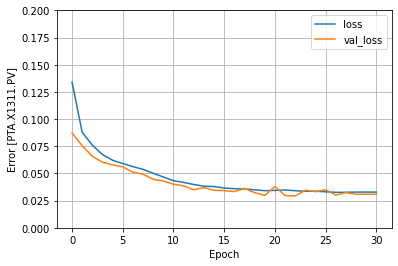

In [29]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0.00, 0.2])
  plt.xlabel('Epoch')
  plt.ylabel('Error [PTA.X1311.PV]')
  plt.legend()
  plt.grid(True)
plot_loss(size_histories)

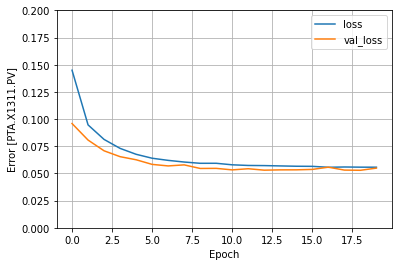

In [38]:
# 50, 25, 10, 1, mse, softmax+sigmoid (klasyfikacja)
plot_loss(size_histories)

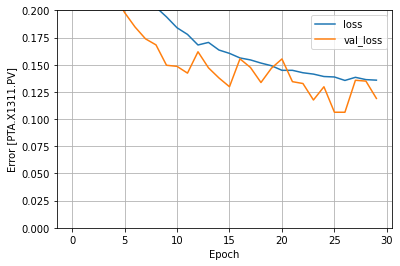

In [56]:
# 50, 25, 10, 1, binary_crossentrpoy, sigmoid (klasyfikacja)
plot_loss(size_histories)

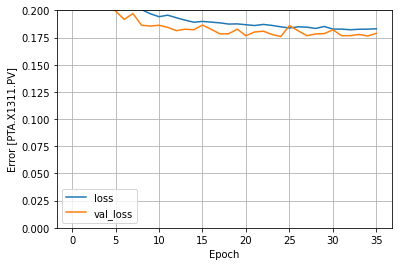

In [47]:
# 50, 25, 10, 1, binary_crossentrpoy, softmax+sigmoid (klasyfikacja)
plot_loss(size_histories)

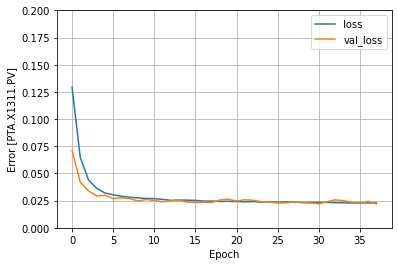

In [65]:
#'PTA.X1311.PV_TRAN', [50, 25, 10], 'mse', False, 'sigmoid'
plot_loss(size_histories)

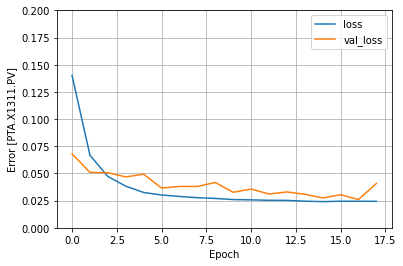

In [74]:
#'PTA.X1311.PV_TRAN', [50, 25, 10], 'mse', False, 'sigmoid'
plot_loss(size_histories)

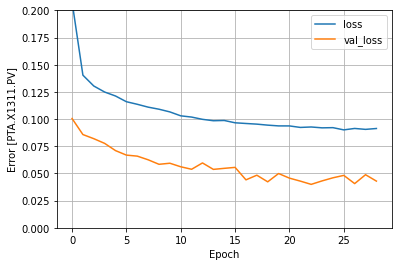

In [82]:
#'PTA.X1311.PV_TRAN', [15, 10, 5], 'mse', False, 'sigmoid')
plot_loss(size_histories)

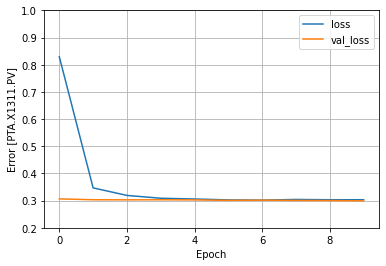

In [90]:
#'PTA.X1311.PV', [15, 10, 5], 'binary_crossentropy', False, 'relu'
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0.2, 1])
  plt.xlabel('Epoch')
  plt.ylabel('Error [PTA.X1311.PV]')
  plt.legend()
  plt.grid(True)
plot_loss(size_histories)

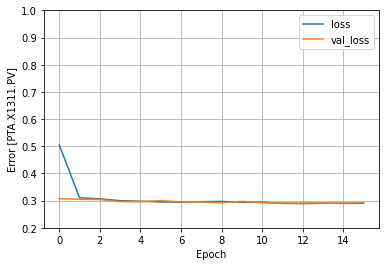

In [101]:
'PTA.X1311.PV', [50, 25, 10], 'binary_crossentropy', False, 'relu'
plot_loss(size_histories)

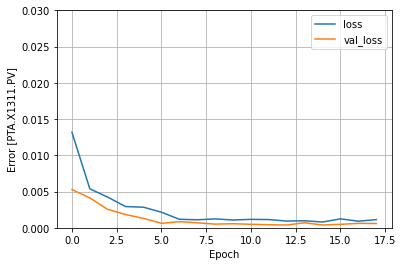

In [108]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0.0, 0.03])
  plt.xlabel('Epoch')
  plt.ylabel('Error [PTA.X1311.PV]')
  plt.legend()
  plt.grid(True)
plot_loss(size_histories)

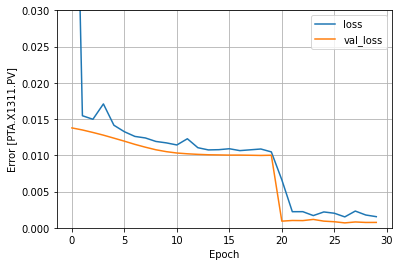

In [113]:
#'PTA.X1311.PV', [20, 10, 5], 'mse', False, 'relu'
plot_loss(size_histories)

2022-08-09 22:00:02.395619: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


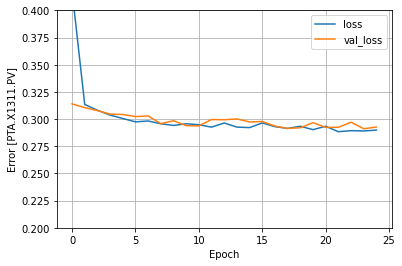

In [119]:
#'PTA.X1311.PV', [128, 64, 16], 'binary_crossentropy', False, 'relu')
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0.2, 0.4])
  plt.xlabel('Epoch')
  plt.ylabel('Error [PTA.X1311.PV]')
  plt.legend()
  plt.grid(True)
plot_loss(size_histories)

In [121]:
prediction_results = dnn_model.predict(test_features)

2022-08-09 22:09:28.439192: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [120]:
dnn_model.evaluate(test_features, test_labels, verbose=0)
# 'loss', 'mae', 'mse', 'mean_absolute_percentage_error', 'mean_squared_logarithmic_error'

[0.2914630174636841,
 0.007923813536763191,
 0.0003656336048152298,
 40151.26171875,
 0.2909295856952667]

In [ ]:
# klasyfikacja sieć 50,25,10,1 - mse, relu
plot_true_vs_prediction(test_labels, prediction_results, -0.5, 1.5)

In [ ]:

# klasyfikacja sieć 50,25,10,1 - mse, sigmoid
plot_true_vs_prediction(test_labels, prediction_results, -0.5, 1.5)

In [ ]:
# klasyfikacja sieć 50,25,10,1 - mse, softmax+sigmoid
plot_true_vs_prediction(test_labels, prediction_results, -0.5, 1.5)

In [ ]:
# klasyfikacja sieć 50,25,10,1 - binary_cross, softmax+sigmoid
plot_true_vs_prediction(test_labels, prediction_results, -0.5, 1.5)

In [ ]:
# klasyfikacja sieć 50,25,10,1 - binary_cross, sigmoid
plot_true_vs_prediction(test_labels, prediction_results, -0.5, 1.5)

In [ ]:
# klasyfikacja sieć 128,64,10,1 - mse, sigmoid
plot_true_vs_prediction(test_labels, prediction_results, -0.5, 1.5)

In [ ]:
plot_true_vs_prediction(test_labels, prediction_results, -0.5, 1.5)

In [ ]:
# malutki 20, 10, 5, 1, mse, sigmoid
plot_true_vs_prediction(test_labels, prediction_results, -0.5, 1.5)

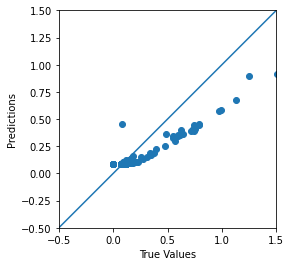

In [97]:
# regresja 50, 25, 10, 1, mse, relu
plot_true_vs_prediction(test_labels, prediction_results, -0.5, 1.5)

In [94]:
#  regreska 'PTA.X1311.PV', [15, 10, 5], 'binary_crossentropy', False, 'relu'
plot_true_vs_prediction(test_labels, prediction_results, -0.5, 2.0)

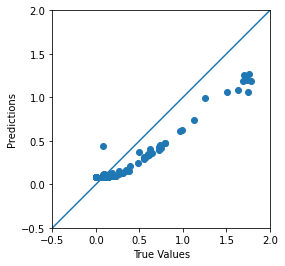

In [104]:
#'PTA.X1311.PV', [50, 25, 10], 'binary_crossentropy', False, 'relu'
plot_true_vs_prediction(test_labels, prediction_results, -0.5, 2.0)

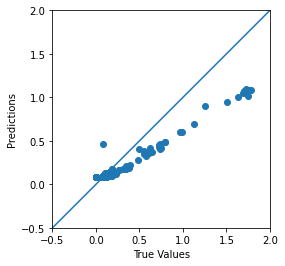

In [111]:
#'PTA.X1311.PV', [50, 25, 10], 'mse', False, 'relu'
plot_true_vs_prediction(test_labels, prediction_results, -0.5, 2.0)

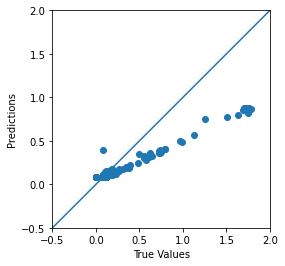

In [116]:
#'PTA.X1311.PV', [20, 10, 5], 'mse', False, 'relu'
plot_true_vs_prediction(test_labels, prediction_results, -0.5, 2.0)

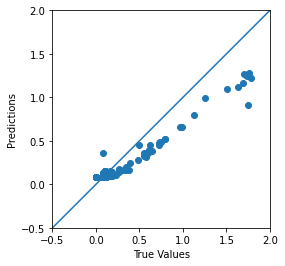

In [122]:
plot_true_vs_prediction(test_labels, prediction_results, -0.5, 2.0)

In [85]:
# zamiana wartości na klasyfikacje
def zaokraglij(value):
    if value >= 0.5:
        return 1
    else:
        return 0

def ocen(real_value, predicted_value):
    if(real_value == 0 and predicted_value == 0): return 'TN'
    if(real_value == 0 and predicted_value == 1): return 'FP'
    if(real_value == 1 and predicted_value == 0): return 'FN'
    if(real_value == 1 and predicted_value == 1): return 'TP'
    
#   dataset_reduced[key] = dataset_reduced.apply(lambda x: replaceStringWithNumber(x[key]), axis=1)
#pd_dataset_output_keys['PTA.X1311.PV_TRAN'] = pd_dataset_output_keys.apply(lambda x: zamian_na_klasyfikacje(x['PTA.X1311.PV']), axis=1)

pd_prediction_results = pd.DataFrame(prediction_results)
pd_prediction_results['rounded'] = pd_prediction_results.apply(lambda x: zaokraglij(x[0]), axis=1)

pd_prediction_results.reset_index(drop=True, inplace=True)
test_labels.reset_index(drop=True, inplace=True)
pd_prediction_results =  pd.concat([pd_prediction_results, test_labels], axis=1)
pd_prediction_results['label'] = pd_prediction_results.apply(lambda x: ocen(x['PTA.X1311.PV_TRAN'], x['rounded']), axis=1)

In [25]:
# klasyfikacja 50, 25, 10, 1, mse, relu
pd_prediction_results['label'].value_counts()

TP    7731
TN    6172
FP     562
FN      96
Name: label, dtype: int64

In [34]:
# klasyfikacja 50, 25, 10, 1, mse, sigmoid
pd_prediction_results['label'].value_counts()

TP    7978
TN    6104
FP     315
FN     164
Name: label, dtype: int64

In [43]:
# klasyfikacja 50, 25, 10, 1, mse, softmax+sigmoid
pd_prediction_results['label'].value_counts()

TP    7639
TN    6065
FP     654
FN     203
Name: label, dtype: int64

In [52]:
# klasyfikacja 50, 25, 10, 1, crossentrpoy, softmax+sigmoid
pd_prediction_results['label'].value_counts()

TP    7599
TN    6160
FP     694
FN     108
Name: label, dtype: int64

In [61]:
# klasyfikacja 50, 25, 10, 1, crossentrpoy, sigmoid
pd_prediction_results['label'].value_counts()

TP    7605
TN    6254
FP     688
FN      14
Name: label, dtype: int64

In [86]:
#'PTA.X1311.PV_TRAN', [15, 10, 5], 'mse', False, 'sigmoid'
pd_prediction_results['label'].value_counts()

TN    7611
TP    6179
FP     682
FN      89
Name: label, dtype: int64

In [70]:
# klasyfikacja 50, 25, 10, 1, mse, sigmoid - z zaokraglaniem etykiet 0,07 - 0,09 => 1
pd_prediction_results['label'].value_counts()

TN    11099
TP     3112
FP      175
FN      175
Name: label, dtype: int64

In [77]:
# klasyfikacja 50, 25, 10, 1, mse, sigmoid - z zaokraglaniem etykiet 0,07 - 0,09 => 1
pd_prediction_results['label'].value_counts()

TP    11235
TN     2628
FP      659
FN       39
Name: label, dtype: int64

In [71]:
pd_prediction_results.count()

0                    14561
rounded              14561
PTA.X1311.PV_TRAN    14561
label                14561
dtype: int64

In [73]:
# klasyfikacja 128, 64, 10, 1, mse, sigmoid
pd_prediction_results['label'].value_counts()

TP    8188
TN    5769
FN     499
FP     105
Name: label, dtype: int64

In [82]:
# klasyfikacja ('PTA.X1311.PV_TRAN', [512, 128, 32], 'mse', False, 'sigmoid')
pd_prediction_results['label'].value_counts()

TP    7568
TN    6204
FP     725
FN      64
Name: label, dtype: int64

In [90]:
# klasyfikacja ('PTA.X1311.PV_TRAN', [20, 10, 5], 'mse', False, 'sigmoid')
pd_prediction_results['label'].value_counts()

TP    7843
TN    5851
FP     450
FN     417
Name: label, dtype: int64

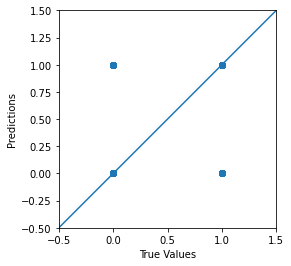

In [74]:
plot_true_vs_prediction(test_labels, pd_prediction_results['rounded'], -0.5, 1.5)

In [ ]:
for i in range(len(test_labels)):
    

In [146]:
# regresja crossnetrpoy duża siec -> relu
plot_true_vs_prediction(test_labels, prediction_results, 0.0, 2.0)

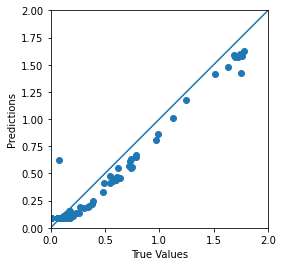

In [150]:
# regresja crossnetrpoy mała sieć -> relu
plot_true_vs_prediction(test_labels, prediction_results, 0.0, 2.0)

In [ ]:
# klasyfikacja crossnetrpoy mała sieć -> relu
plot_true_vs_prediction(test_labels, prediction_results, 0.0, 2.0)

In [ ]:
# klasyfikacja crossnetrpoy mała sieć -> softmax
plot_true_vs_prediction(test_labels, prediction_results, 0.0, 1.0)

In [ ]:
# klasyfikacja crossnetrpoy mała sieć -> sigmoid
plot_true_vs_prediction(test_labels, prediction_results, -0.5, 2.0)

In [ ]:
# klasyfikacja mse mała sieć -> sigmoid
plot_true_vs_prediction(test_labels, prediction_results, -0.5, 2.0)

In [185]:
test_labels['PTA.X1311.PV_TRAN'].count()-test_labels['PTA.X1311.PV_TRAN'].sum()

8293

In [183]:
test_labels['PTA.X1311.PV_TRAN'].sum()

6268

In [210]:
prr = pd.DataFrame(prediction_results)
prr[0].sum()

6349.1436

In [ ]:
prr

In [191]:
xyz = test_labels['PTA.X1311.PV_TRAN']-prr[0]
prr

0
0      1.156925e-07
1      1.324824e-07
2      2.072043e-07
3      9.724476e-08
4      1.917507e-07
...             ...
14556  9.863014e-01
14557  9.745040e-01
14558  9.822615e-01
14559  9.787720e-01
14560  9.781845e-01

[14561 rows x 1 columns]